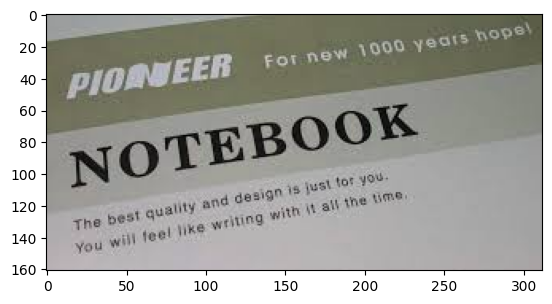

In [33]:
#YCrCb

import cv2
import numpy as np
import matplotlib.pyplot as plt


image = cv2.imread(r'C:\Users\lenovo\Desktop\CV-Lab\TermPaper\notebook.jpg')
plt.imshow(image)
ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
Y, Cr, Cb = cv2.split(ycrcb_image)

inv_Y = 255 - Y
inv_Cr = 255 - Cr
inv_Cb = 255 - Cb

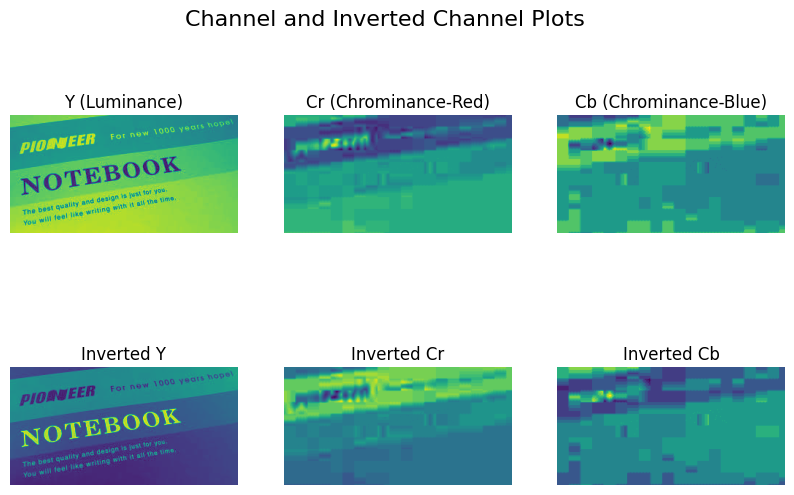

In [34]:
#Plotting 6 channels of YCrCb

fig, axes = plt.subplots(2, 3, figsize=(10, 6))


images_titles = [
    (Y, 'Y (Luminance)'),
    (Cr, 'Cr (Chrominance-Red)'),
    (Cb, 'Cb (Chrominance-Blue)'),
    (inv_Y, 'Inverted Y'),
    (inv_Cr, 'Inverted Cr'),
    (inv_Cb, 'Inverted Cb')
]


for i, (image, title) in enumerate(images_titles):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(image)
    axes[row, col].set_title(title)
    axes[row, col].axis('off')
fig.suptitle('Channel and Inverted Channel Plots', fontsize=16)
plt.show()

In [35]:
#Applying Binary Threshold

def threshold_channel(channel, threshold=127):
    _, thresh = cv2.threshold(channel, threshold, 255, cv2.THRESH_BINARY)
    return thresh


thresh_Y = threshold_channel(Y)
thresh_Cr = threshold_channel(Cr)
thresh_Cb = threshold_channel(Cb)

thresh_inv_Y = threshold_channel(inv_Y)
thresh_inv_Cr = threshold_channel(inv_Cr)
thresh_inv_Cb = threshold_channel(inv_Cb)


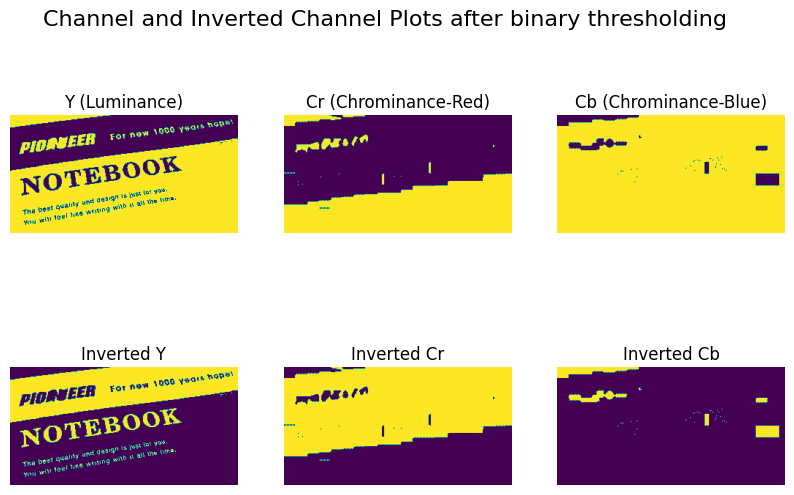

In [36]:
#Plotting after Binary Threshold

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
thresh_images_titles = [
    (thresh_Y, 'Y (Luminance)'),
    (thresh_Cr, 'Cr (Chrominance-Red)'),
    (thresh_Cb, 'Cb (Chrominance-Blue)'),
    (thresh_inv_Y, 'Inverted Y'),
    (thresh_inv_Cr, 'Inverted Cr'),
    (thresh_inv_Cb, 'Inverted Cb')
]


for i, (image, title) in enumerate(thresh_images_titles):
    row = i // 3
    col = i % 3

    axes[row, col].imshow(image)
    axes[row, col].set_title(title)
    axes[row, col].axis('off')
fig.suptitle('Channel and Inverted Channel Plots after binary thresholding', fontsize=16)
plt.show()

In [39]:
#Extremal Regions
er_data={}
def generate_mask_for_image(thresh_image,title):
   
    num_labels, labels, stats, centroids = find_connected_components(thresh_image)
    mask = np.zeros(thresh_image.shape, dtype="uint8")
    
    
    for i in range(1, num_labels):
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        # ratio = w/h
       
        keepWidth = w > 10 and w < 200
        keepHeight = h > 20 and h < 650
        keepArea = area > 10 and area < 1500
        # keepRatio = ratio >=0.3 and ratio <= 1
        
        #
        Listmask=[]
        if all((keepWidth, keepHeight, keepArea)):
            
            # print(f"[INFO] keeping connected component '{i}'")
            componentMask = (labels == i).astype("uint8") * 255
            mask = cv2.bitwise_or(mask, componentMask)
            Listmask.append(componentMask)
            # print(mask)
            # plt.plot(componentMask)
        er_data[title]=(num_labels, labels)

        # for masked in Listmask:
        #     plt.imshow(masked)
        #     plt.show()
       
    
    return mask,er_data


def find_connected_components(binary_image):
    num_labels, labels, stats,centroids = cv2.connectedComponentsWithStats(binary_image)
    
    return num_labels, labels, stats,centroids


cc_thresh_Y=generate_mask_for_image(thresh_Y,'Y')
cc_thresh_Cr=generate_mask_for_image(thresh_Cr,'Cr')
cc_thresh_Cb=generate_mask_for_image(thresh_Cb,'Cb')
cc_thresh_inv_Y=generate_mask_for_image(thresh_inv_Y,'inv Y')
cc_thresh_inv_Cr=generate_mask_for_image(thresh_inv_Cr,'inv Cr')
cc_thresh_inv_Cb=generate_mask_for_image(thresh_inv_Cb, 'inv Cb')


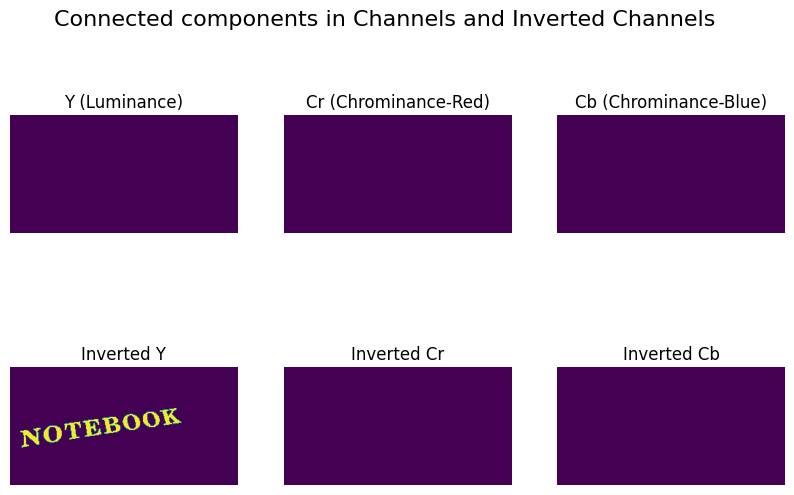

In [40]:
#Plotting Connected Components
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

cc_thresh_images_titles = [
    (cc_thresh_Y[0], 'Y (Luminance)'),
    (cc_thresh_Cr[0], 'Cr (Chrominance-Red)'),
    (cc_thresh_Cb[0], 'Cb (Chrominance-Blue)'),
    (cc_thresh_inv_Y[0], 'Inverted Y'),
    (cc_thresh_inv_Cr[0], 'Inverted Cr'),
    (cc_thresh_inv_Cb[0], 'Inverted Cb')
]

for i, (image, title) in enumerate(cc_thresh_images_titles):
    row = i // 3
    col = i % 3

    axes[row, col].imshow(image)
    axes[row, col].set_title(title)
    axes[row, col].axis('off')
fig.suptitle('Connected components in Channels and Inverted Channels', fontsize=16)
plt.show()

In [41]:
# Intersection-over-Union (IoU)
def calculate_iou(box1, box2):

    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

#Non-Maximum Suppression (NMS)
def non_maximum_suppression(er_data, iou_threshold=0.5):
    
    final_er_boxes = []

    for channel_name, (num_labels, labels) in er_data.items():
        bounding_boxes = []

        
        for label in range(1, num_labels):  # Skip background label (0)
            er_mask = (labels == label).astype(np.uint8)

            
            x, y, w, h = cv2.boundingRect(er_mask)
            bounding_boxes.append((x, y, x + w, y + h))  # (x1, y1, x2, y2)

        
        bounding_boxes = np.array(bounding_boxes)
        selected_boxes = []

        while len(bounding_boxes) > 0:
            chosen_box = bounding_boxes[0]
            selected_boxes.append(chosen_box)

            to_remove = []
            for i in range(1, len(bounding_boxes)):
                iou = calculate_iou(chosen_box, bounding_boxes[i])

                if iou > iou_threshold:
                    to_remove.append(i)

            bounding_boxes = np.delete(bounding_boxes, [0] + to_remove, axis=0)

        final_er_boxes.extend(selected_boxes)

    return final_er_boxes


final_er_boxes = non_maximum_suppression(er_data, iou_threshold=0.5)




In [42]:

def visualize_final_er_boxes(image, final_er_boxes):
    for (x1, y1, x2, y2) in final_er_boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Final ERs After Non-Maximum Suppression')
    plt.axis('off')
    plt.show()

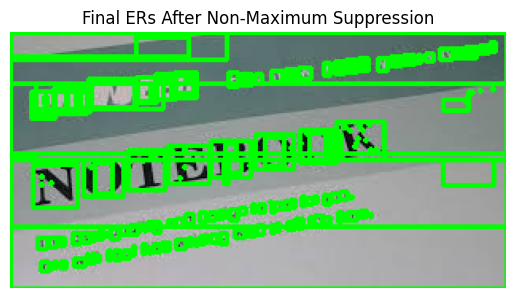

In [44]:
# Load the original image again for visualization
image = cv2.imread('C:/Users/lenovo/Desktop/CV-Lab/TermPaper/notebook.jpg')

visualize_final_er_boxes(image, final_er_boxes)